In [2]:
import itertools
import yaml

run_path = './runs_multicore'

device_list     = ['DDR4', 'ULTRARAM', 'FULTRARAM']
org_list        = ['2Gb_x8', '4Gb_x8', '8Gb_x8', '16Gb_x8']
timing_list     = ['1600L', '1866N', '2400T', '2933AA', '3200AC']
row_policy_list = ['ClosedRowPolicy', 'OpenRowPolicy']

group_list = ["HHHH", "HHHL", "HHLL", "HLLL", "LLLL"]
num_samples_per_group = 5
trace_list = [x[0] + str(x[1]) for x in itertools.product(group_list, range(num_samples_per_group))]

data = {}
for device in device_list:
  for org in org_list:
    for timing in timing_list:
      for row_policy in row_policy_list:
        for trace in trace_list:
            run_file = f'{device}_{org}_{timing}_{row_policy}_{trace}'
            with(open(f'{run_path}/{run_file}.yaml', 'r')) as f:
              data[run_file] = yaml.load(f, Loader=yaml.FullLoader)

/tmp/ipykernel_58780/1847313302.py:55: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  barplot = sns.barplot(x='Benchmark', y='Normalized Core Cycle', hue='Device',


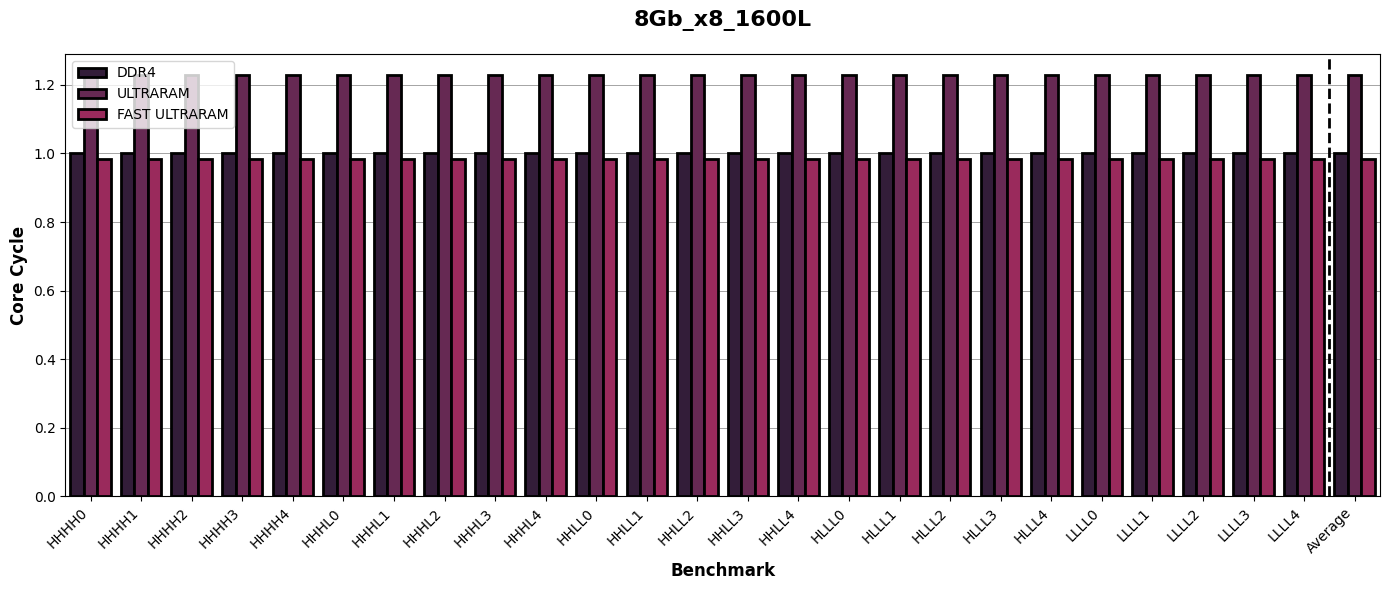

/tmp/ipykernel_58780/1847313302.py:55: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  barplot = sns.barplot(x='Benchmark', y='Normalized Core Cycle', hue='Device',


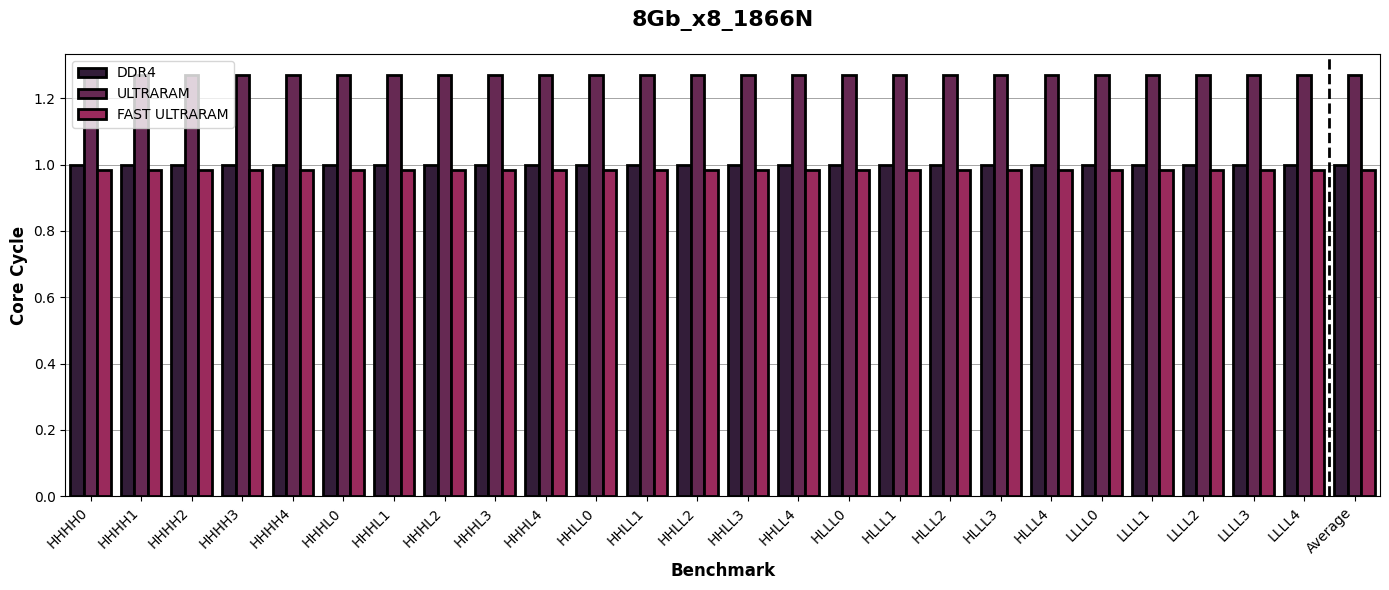

/tmp/ipykernel_58780/1847313302.py:55: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  barplot = sns.barplot(x='Benchmark', y='Normalized Core Cycle', hue='Device',


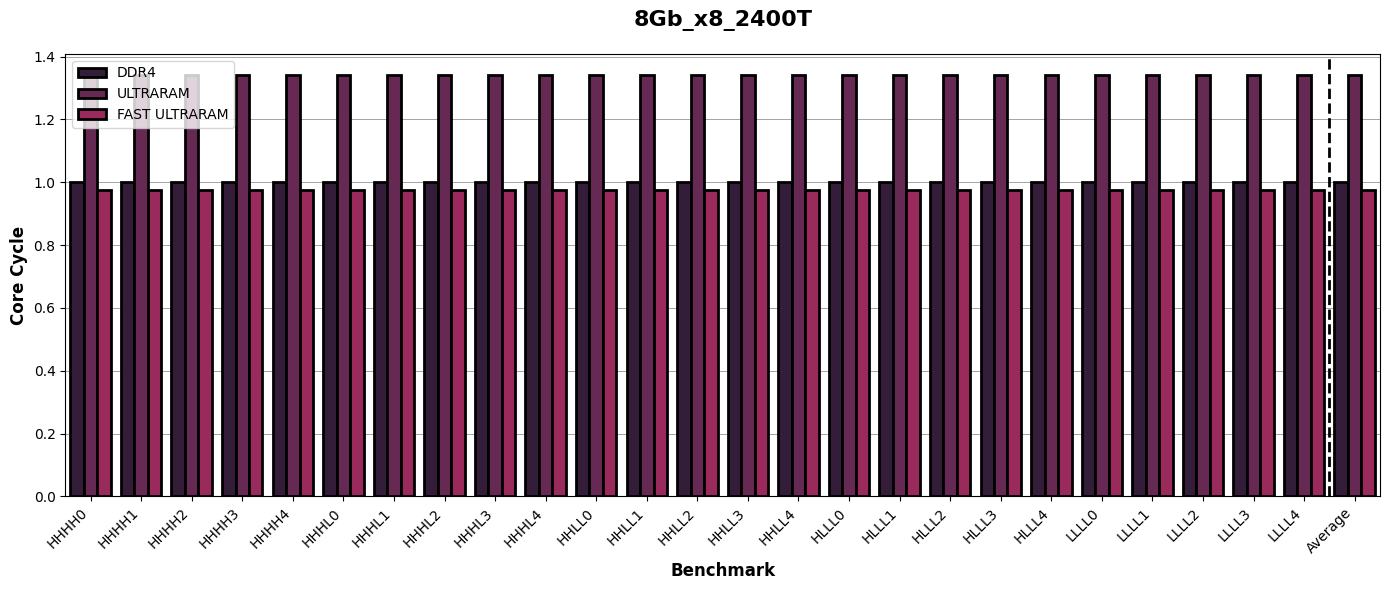

/tmp/ipykernel_58780/1847313302.py:55: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  barplot = sns.barplot(x='Benchmark', y='Normalized Core Cycle', hue='Device',


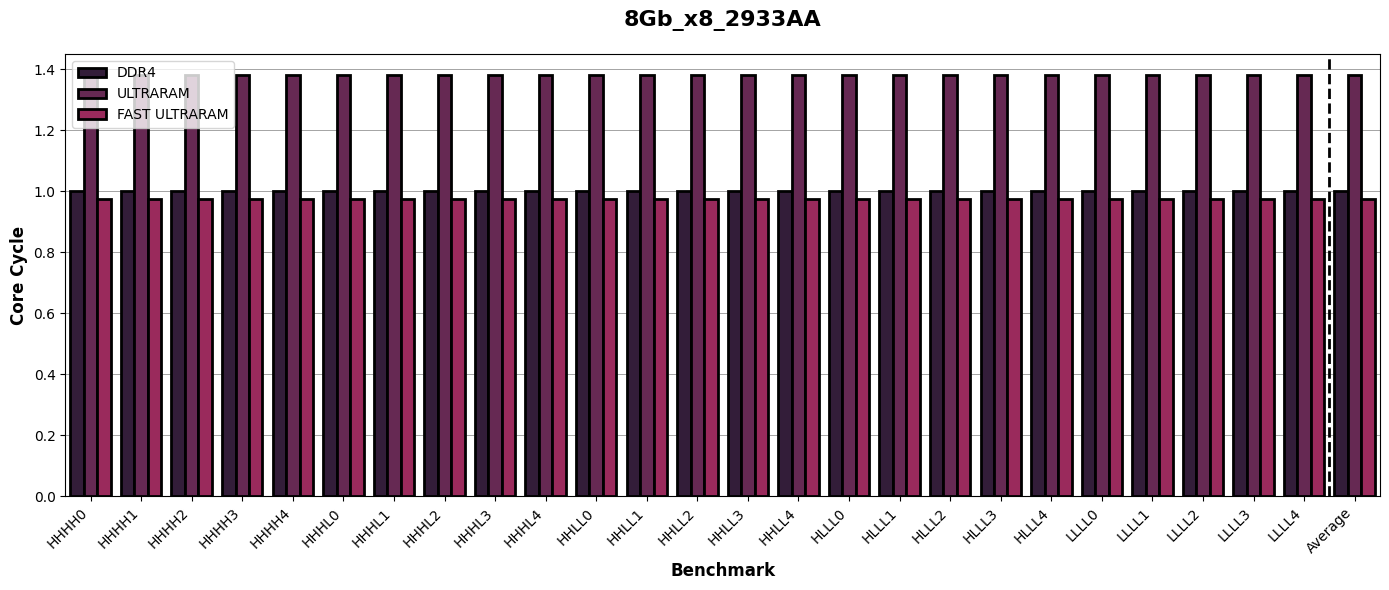

/tmp/ipykernel_58780/1847313302.py:55: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  barplot = sns.barplot(x='Benchmark', y='Normalized Core Cycle', hue='Device',


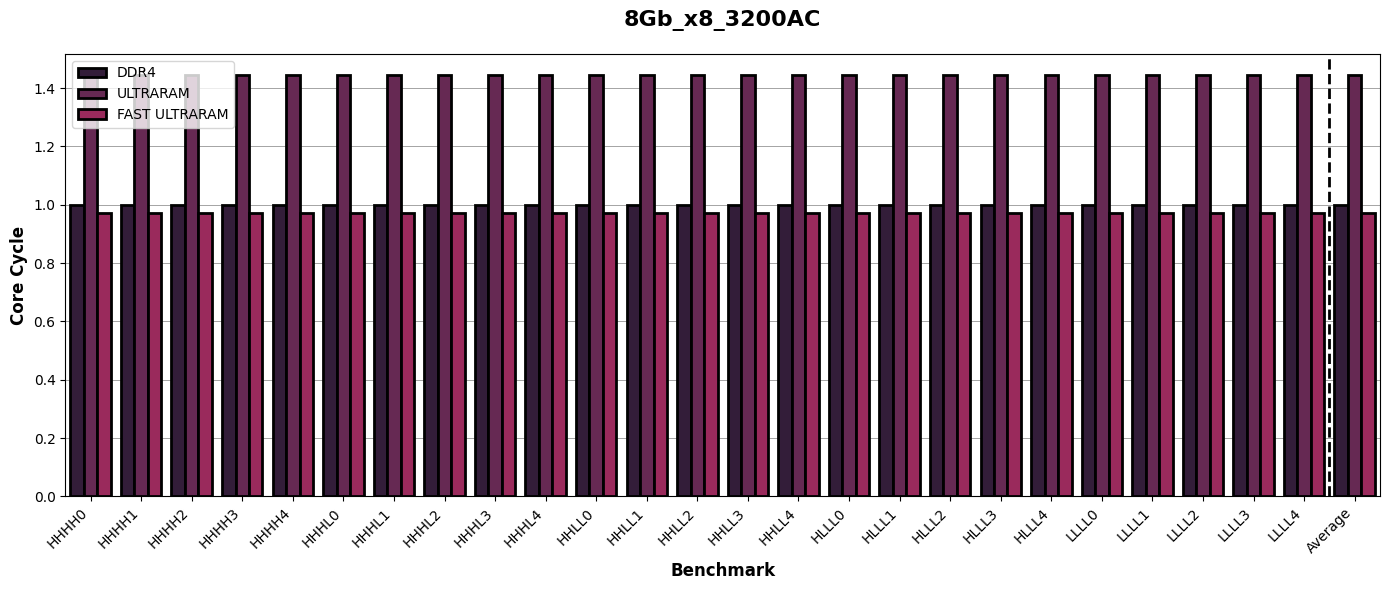

/tmp/ipykernel_58780/1847313302.py:55: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  barplot = sns.barplot(x='Benchmark', y='Normalized Core Cycle', hue='Device',


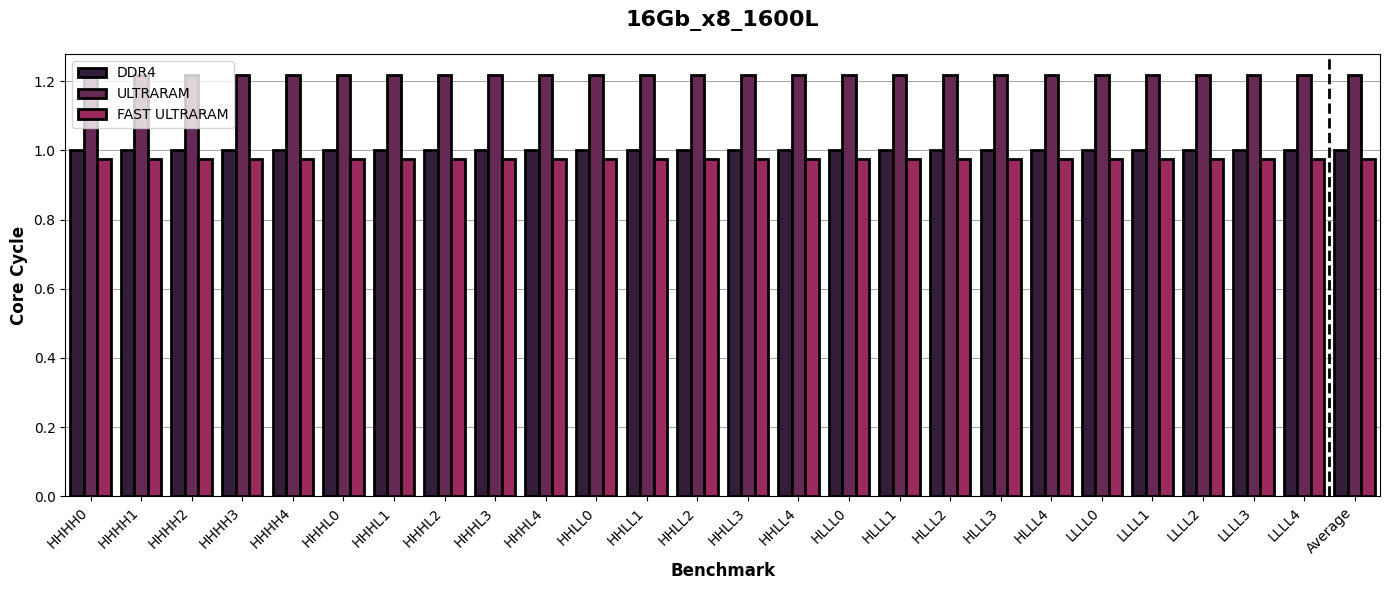

/tmp/ipykernel_58780/1847313302.py:55: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  barplot = sns.barplot(x='Benchmark', y='Normalized Core Cycle', hue='Device',


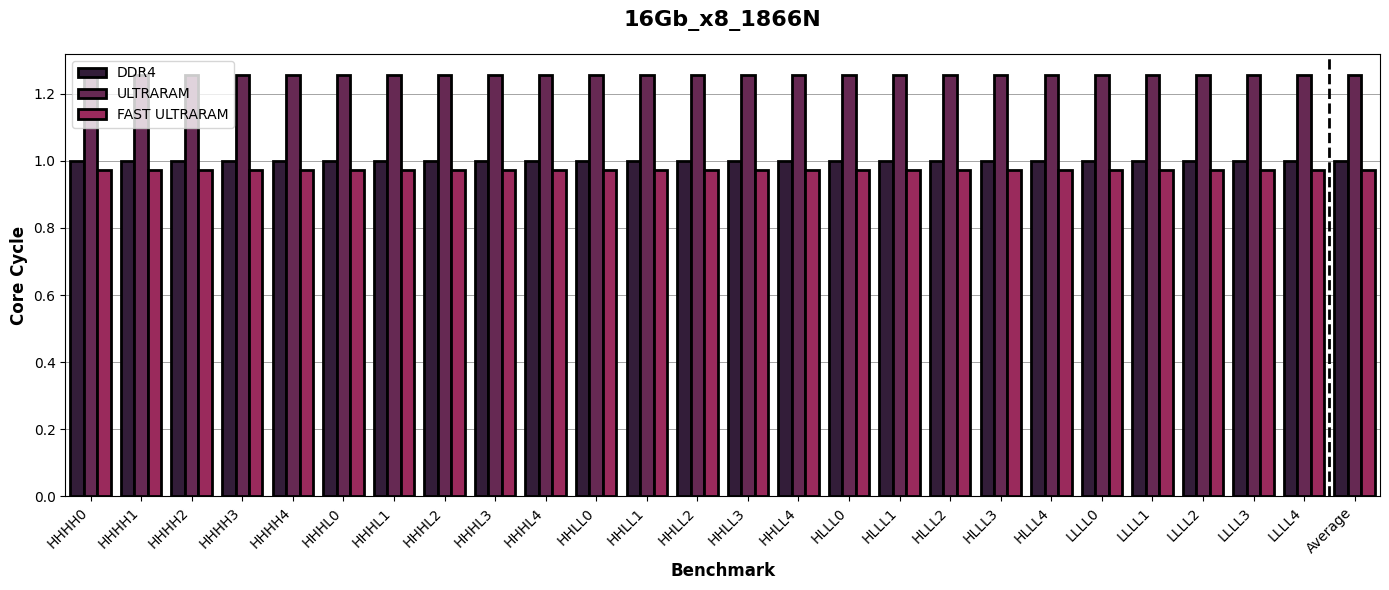

/tmp/ipykernel_58780/1847313302.py:55: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  barplot = sns.barplot(x='Benchmark', y='Normalized Core Cycle', hue='Device',


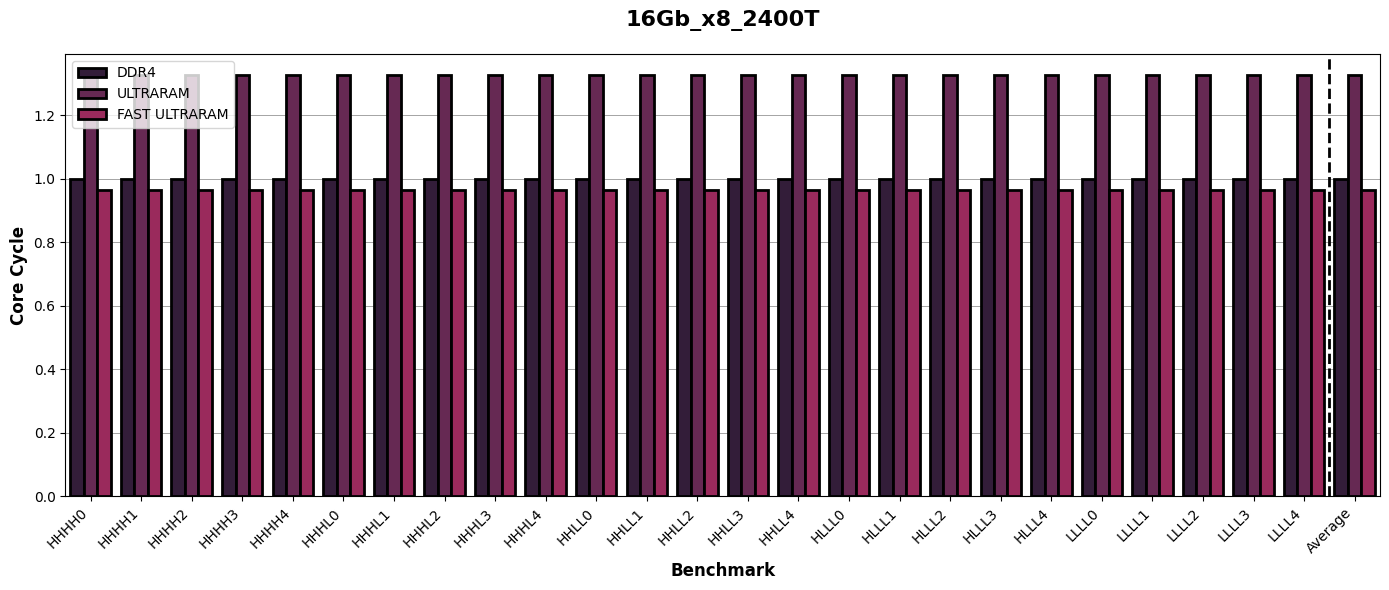

/tmp/ipykernel_58780/1847313302.py:55: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  barplot = sns.barplot(x='Benchmark', y='Normalized Core Cycle', hue='Device',


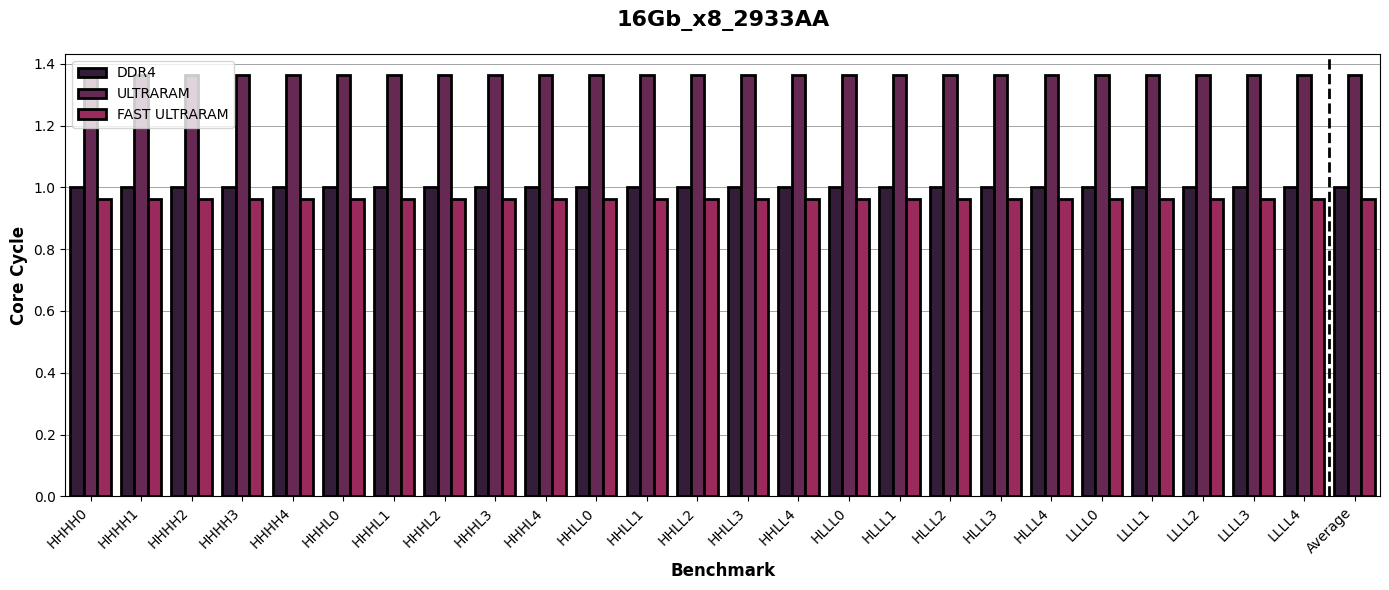

/tmp/ipykernel_58780/1847313302.py:55: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  barplot = sns.barplot(x='Benchmark', y='Normalized Core Cycle', hue='Device',


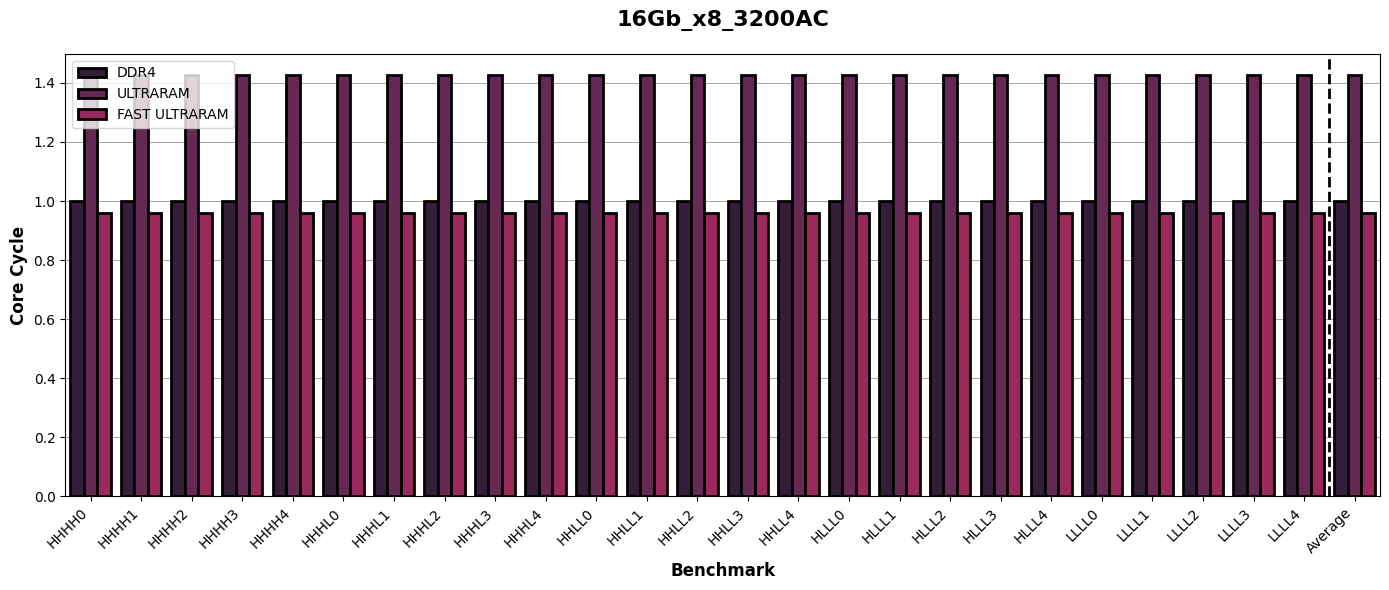

In [7]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

device_list     = ['DDR4', 'ULTRARAM', 'FULTRARAM']
org_list        = ['8Gb_x8', '16Gb_x8']
timing_list     = ['1600L', '1866N', '2400T', '2933AA', '3200AC']
row_policy_list = ['ClosedRowPolicy']

group_list = ["HHHH", "HHHL", "HHLL", "HLLL", "LLLL"]
num_samples_per_group = 5
trace_list = [x[0] + str(x[1]) for x in itertools.product(group_list, range(num_samples_per_group))]

for org in org_list:
   for timing in timing_list:
      for row_policy in row_policy_list:
        dram_core_cycle_list = []
        uram_core_cycle_list = []
        furam_core_cycle_list = []

        for trace in trace_list:
          dram_core_cycle_list.append(data[f'DDR4_{org}_{timing}_{row_policy}_{trace}']['Frontend']['cycles_recorded_core_0'])
          uram_core_cycle_list.append(data[f'ULTRARAM_{org}_{timing}_{row_policy}_{trace}']['Frontend']['cycles_recorded_core_0'])
          furam_core_cycle_list.append(data[f'FULTRARAM_{org}_{timing}_{row_policy}_{trace}']['Frontend']['cycles_recorded_core_0'])

        sorted_data = sorted(zip(trace_list, dram_core_cycle_list, uram_core_cycle_list, furam_core_cycle_list),
                      key=lambda x: x[2])
        benchmarks = []
        core_cycles = []
        devices = []

        for trace, dram_value, uram_value, furam_value in sorted_data:
            benchmarks.extend([trace, trace, trace])
            core_cycles.extend([1.0, uram_value / dram_value, furam_value / dram_value])
            devices.extend(['DDR4', 'ULTRARAM', 'FAST ULTRARAM'])

        avg_ddr4  = 1
        avg_uram  = np.mean(np.array(uram_core_cycle_list) / np.array(dram_core_cycle_list))
        avg_furam = np.mean(np.array(furam_core_cycle_list) / np.array(dram_core_cycle_list))


        for _ in range(3):
          benchmarks.extend(['Average', 'Average', 'Average'])
          core_cycles.extend([avg_ddr4, avg_uram, avg_furam])
          devices.extend(['DDR4', 'ULTRARAM', 'FAST ULTRARAM'])

        df = pd.DataFrame({
            'Benchmark': benchmarks,
            'Normalized Core Cycle': core_cycles,
            'Device': devices
        })

        plt.figure(figsize=(14, 6))
        barplot = sns.barplot(x='Benchmark', y='Normalized Core Cycle', hue='Device', 
                              edgecolor='black', linewidth=2, 
                              palette=sns.color_palette('rocket'), 
                              zorder=2, data=df)

        barplot.legend(loc='upper left')
        barplot.set_xlabel('Benchmark', fontsize=12, fontweight='bold')
        barplot.set_ylabel('Core Cycle', fontsize=12, fontweight='bold')
        barplot.grid(True, which='major', axis='y', linestyle='-', linewidth=0.5, color='gray', zorder=0)

        plt.xticks(rotation=45, ha='right')
        plt.title(f'{org}_{timing}', fontsize=16, fontweight='bold', pad=20)
        plt.axvline(x=len(trace_list) - 0.5, color='black', linestyle='--', linewidth=2)

        plt.tight_layout()
        plt.show()